In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import re
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
###
data_dir = 'train_cluster_cleaned/' 
#trained data 

cluster_numbers = list(range(1, 29))
cluster_folders = [os.path.join(data_dir, f'cluster_{i}') for i in cluster_numbers]

all_images = []
all_labels = []

for folder in cluster_folders:
    file_names = os.listdir(folder)
    for file_name in file_names:
        cell_id = int(file_name.split('_')[1].split('.')[0])
        img = cv2.imread(os.path.join(folder, file_name))
        
        all_images.append(img)
        all_labels.append(f'cluster_{folder.split("_")[-1]}')

all_images = np.array(all_images)
all_labels = np.array(all_labels)

train_images, validation_images, train_labels, validation_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

lb = sklearn.preprocessing.LabelEncoder()
train_labels = lb.fit_transform(train_labels)
validation_labels = lb.transform(validation_labels)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=len(cluster_numbers))
validation_labels = tf.keras.utils.to_categorical(validation_labels, num_classes=len(cluster_numbers))

train_images = train_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0

In [2]:
print(len(train_images))

23386


In [3]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cluster_numbers = list(range(1, 29))
image_size = 224
num_classes = len(cluster_numbers)
batch_size = 128

# Define the custom object ClassToken
class ClassToken(layers.Layer):
    def __init__(self, **kwargs):
        super(ClassToken, self).__init__(**kwargs)

    def build(self, input_shape):
        self.class_token = self.add_weight(
            shape=(1, 1, input_shape[3]),
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            name="class_token",
        )
        super(ClassToken, self).build(input_shape)

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Add a class token
        class_token = tf.broadcast_to(self.class_token, [batch_size, 1, 1, tf.shape(self.class_token)[2]])
        x = tf.concat([class_token, x], axis=1)
        return x


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=128,
    shuffle=True
)

# Load the pre-trained ResNet50V2 model without the top layer (global average pooling and fully connected layers)
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the top layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few convolutional layers and the batch normalization layers
for layer in base_model.layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Add new top layers for the new dataset
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Create the new model by combining the base model and the top layers
model = models.Model(inputs=base_model.input, outputs=predictions)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compile the model
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

models_dir = 'saved_4_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(models_dir, 'CNN_whole_clean_optimised_last.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

epochs = 30

# Train the model with model checkpointing
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=(validation_images, validation_labels),
    callbacks=[early_stopping, model_checkpoint]
)

model = tf.keras.models.load_model(os.path.join(models_dir, 'CNN_whole_clean_optimised_last.h5'))

2023-05-15 05:37:15.085483: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 05:37:15.760835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1b:00.0, compute capability: 8.6


94683136/94668760 [==============================] - 11s 0us/step
Epoch 1/30


2023-05-15 05:37:37.421665: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-05-15 05:37:40.788123: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


182/182 [==============================] - ETA: 0s - loss: 5.6782 - accuracy: 0.0835

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


182/182 [==============================] - 332s 2s/step - loss: 5.6782 - accuracy: 0.0835 - val_loss: 5.0996 - val_accuracy: 0.1238
Epoch 2/30
182/182 [==============================] - 318s 2s/step - loss: 4.8510 - accuracy: 0.1133 - val_loss: 4.4435 - val_accuracy: 0.1519
Epoch 3/30
182/182 [==============================] - 318s 2s/step - loss: 4.4037 - accuracy: 0.1248 - val_loss: 4.0622 - val_accuracy: 0.1659
Epoch 4/30
182/182 [==============================] - 326s 2s/step - loss: 4.1097 - accuracy: 0.1363 - val_loss: 3.9004 - val_accuracy: 0.1573
Epoch 5/30
182/182 [==============================] - 314s 2s/step - loss: 3.8919 - accuracy: 0.1462 - val_loss: 3.6645 - val_accuracy: 0.1734
Epoch 6/30
182/182 [==============================] - 322s 2s/step - loss: 3.7407 - accuracy: 0.1472 - val_loss: 3.5630 - val_accuracy: 0.1799
Epoch 7/30
182/182 [==============================] - 313s 2s/step - loss: 3.6085 - accuracy: 0.1500 - val_loss: 3.4004 - val_accuracy: 0.1753
Epoch 8/30

In [5]:
# Create the output_csv folder if it doesn't exist
output_folder = "output_Image4_csv"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the training data to a CSV file
training_data = pd.DataFrame({
    'epoch': np.arange(1, len(history.history['accuracy']) + 1),
    'train_accuracy': history.history['accuracy'],
    'validation_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
})
training_data.to_csv(os.path.join(output_folder, 'history_clean_whole_cnn_2.csv'), index=False)

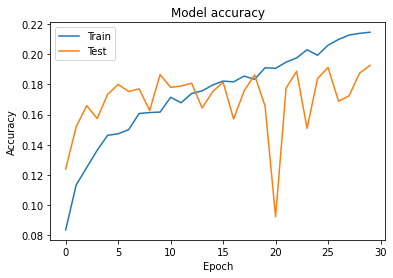

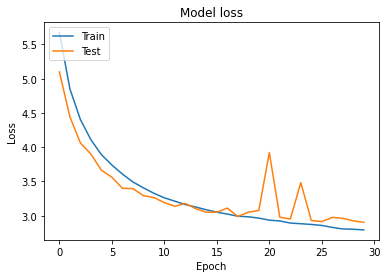

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [7]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = 'test_cluster_cleaned'

# Set up the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Found 7320 images belonging to 28 classes.
57/57 [==============================] - 124s 2s/step - loss: 2.9454 - accuracy: 0.1861
Test loss: 2.9454
Test accuracy: 18.61%


In [8]:
import csv

# Predict on the test data generator
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Get the predicted labels with highest probabilities
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Get the probabilities of the predicted labels
y_pred_probabilities = np.max(y_pred, axis=1)

# Get the filenames of the test data
filenames = test_generator.filenames

# Extract the IDs from the filenames
ids = [filename.split("/")[-1].split("_")[-1].split(".")[0] for filename in filenames]

# Open the CSV file in write mode
with open('output_clean_independent_cnn.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cell ID', 'Label 1', 'Label 2', 'Label 3', 'Probability 1', 'Probability 2', 'Probability 3', 'Test Accuracy', 'Test Loss'])
    
    # Loop through the predictions
    for i in range(len(y_pred)):
        top_3_indices = y_pred[i].argsort()[-3:][::-1]
        top_3_labels = [class_labels[j] for j in top_3_indices]
        top_3_probabilities = y_pred[i][top_3_indices]
        
        # Write the row with predictions and the single test accuracy and test loss value
        writer.writerow([ids[i], top_3_labels[0], top_3_labels[1], top_3_labels[2], top_3_probabilities[0], top_3_probabilities[1], top_3_probabilities[2], test_accuracy, test_loss])

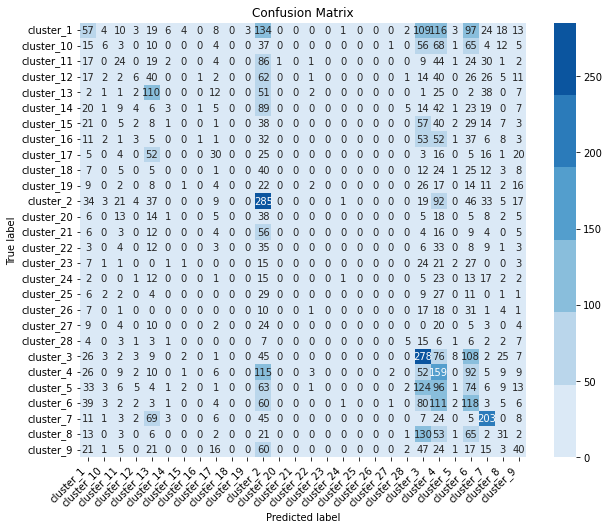

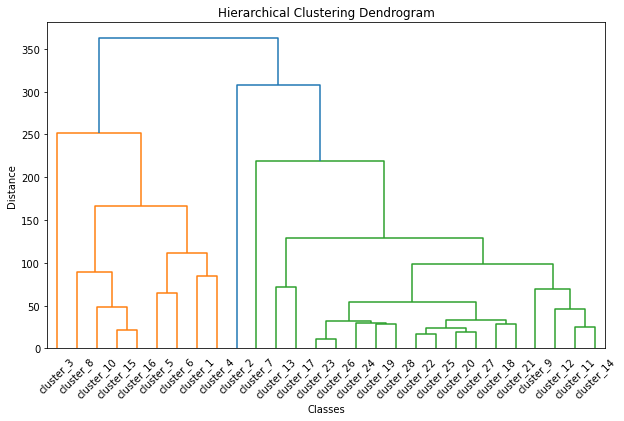

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix

# Get the number of samples in the test data
num_samples = len(y_pred)

# Trim y_pred_labels and y_pred_probabilities to match the number of samples
y_pred_labels = y_pred_labels[:num_samples]

# Create the confusion matrix
confusion_mat = confusion_matrix(test_generator.classes[:num_samples], y_pred_labels)

# Perform hierarchical clustering
Z = linkage(confusion_mat, method='complete')

# Get class labels for display
class_labels = list(test_generator.class_indices.keys())

# Set the color theme to light blue
cmap = sns.color_palette("Blues")

# Create a heatmap of the confusion matrix with light blue color theme
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap=cmap)

# Rotate the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Set labels and title
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")

# Perform hierarchical clustering and plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=class_labels)

# Set labels and title for dendrogram
plt.xlabel("Classes")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")

# Display the plots
plt.show()

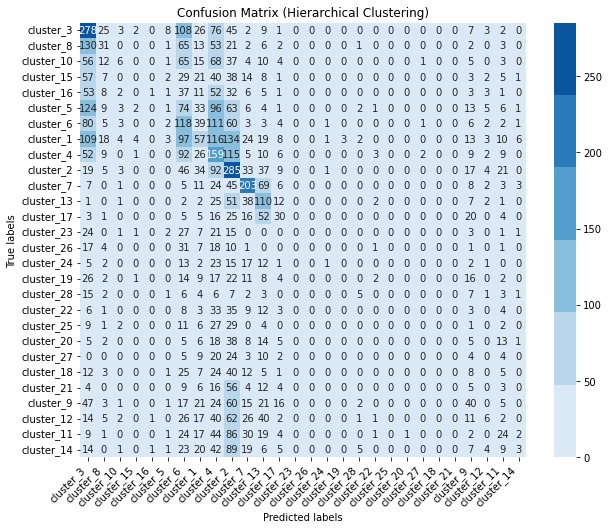

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix

# Get the number of samples in the test data
num_samples = len(y_pred)

# Trim y_pred_labels and y_pred_probabilities to match the number of samples
y_pred_labels = y_pred_labels[:num_samples]

# Create the confusion matrix
confusion_mat = confusion_matrix(test_generator.classes[:num_samples], y_pred_labels)

# Perform hierarchical clustering
Z = linkage(confusion_mat, method='complete')

# Get the order of the clusters from the dendrogram
cluster_order = dendrogram(Z, no_plot=True)['leaves']
reordered_confusion_mat = confusion_mat[cluster_order, :]
reordered_confusion_mat = reordered_confusion_mat[:, cluster_order]

# Get the corresponding class labels for the reordered matrix
reordered_class_labels = [class_labels[idx] for idx in cluster_order]

# Set the color theme to light blue
cmap = sns.color_palette("Blues")

# Create a heatmap of the reordered confusion matrix with light blue color theme
plt.figure(figsize=(10, 8))
ax = sns.heatmap(reordered_confusion_mat, annot=True, fmt="d", xticklabels=reordered_class_labels, yticklabels=reordered_class_labels, cmap=cmap)

# Rotate the tick labels on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Set labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (Hierarchical Clustering)")

# Display the plot
plt.show()

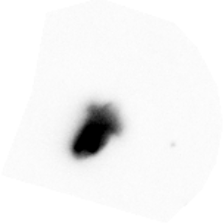

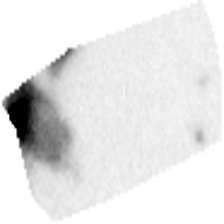

In [10]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import cv2
%matplotlib inline


import numpy as np
import tensorflow as tf
from tensorflow import keras

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

img_size = (224, 224)
#last_conv_layer_name = "dense_3"

# The local path to our target image
img_path = "test_cluster_cleaned/cluster_1/cell_2255.png"
img_path2 = "test_cluster_cleaned/cluster_4/cell_3524.png"

from PIL import Image
from PIL import ImageOps

# Open the image
img = Image.open(img_path)
img2 = Image.open(img_path2)

# Invert the colors
inverted_img = ImageOps.invert(img)
inverted_img2 = ImageOps.invert(img2)

# Display the inverted image
inverted_img.show()
inverted_img2.show()

Predicted class: cluster_7


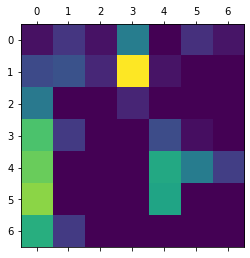

Predicted class: cluster_13


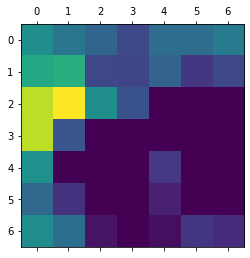

In [12]:
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define function to get last convolutional layer's name
def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
            return layer.name
    raise ValueError("Could not find last convolutional layer in the model.")

# Define function to get image array
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define function to generate class activation heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    conv_model = tf.keras.models.Model(model.inputs, last_conv_layer.output)
    
    # Create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output_shape[1:])
    x = classifier_input
    for layer in model.layers[layer_index:]:
        x = layer(x)
    classifier_model = tf.keras.models.Model(classifier_input, x)
    
    # Get the gradient of the predicted class with respect to the output feature map of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Compute the mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each feature map channel by its corresponding gradient value
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
    # Average the feature map channels to get the heatmap
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    
    # Clip the heatmap between 0 and 1
    heatmap = np.clip(heatmap, 0, 1)
    
    # Return the heatmap
    return heatmap

# Define image path and size

img_size = (224, 224)

# Get last convolutional layer's name
last_conv_layer_name = get_last_conv_layer_name(model)

# Get the index of the last convolutional layer
last_conv_layer = model.get_layer(last_conv_layer_name)
layer_index = model.layers.index(last_conv_layer)


# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print the predicted class label
preds = model.predict(img_array)
predicted_class = np.argmax(preds)
class_labels = list(test_generator.class_indices.keys())
print("Predicted class:", class_labels[predicted_class])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


# Prepare image2
img_array2 = preprocess_input(get_img_array(img_path2, size=img_size))

# Print the predicted class label
preds2 = model.predict(img_array2)
predicted_class2 = np.argmax(preds2)
class_labels = list(test_generator.class_indices.keys())
print("Predicted class:", class_labels[predicted_class2])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array2, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

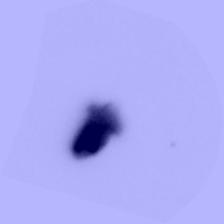

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from IPython.display import display

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Invert the colors
    inverted_img = 255 - img

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + inverted_img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
save_and_display_gradcam(img_path2, heatmap)